This report contains a genetic algorithm implementation written for the first assignment under the Intelligent Systems course at FRI UNI LJ.

# Implementation

This GA implementation was written from scratch. No libraries beyond the Python standard library, numpy and matplotlib were used. However, some inspiration was taken from the DEAP library.

## Population

Each individual is represented as a list of numbers (integers) and operators (single character strings). This is then wrapped inside a class to simplify the object handling.

Alongside some basic helpers, the class contains two more functions to consider:

- `evaluate` - Evaluates the arithmetic expression.
- `score` - The fitness function, calculated as an absolute distance between the expression value and the target value.

In [1]:
from random import seed

# random seed for easier analisys
seed(256)

# task defining features
OPERATORS = ['+', '-', '*', '/']

class Individual:
    def __init__(self) -> None:
        self.expression = []
        self.score = None
    
    def add_operator(self, operator):
        if len(self.expression) % 2 == 0:
            raise "operand expected"
        
        if operator not in OPERATORS:
            raise "not an operator"

        self.expression.append(operator)

    def add_operand(self, operand):
        if len(self.expression) % 2 == 1:
            raise "operator expected"
        
        if type(operand) is not int:
            raise "int expected"

        self.expression.append(operand)

    def calculate_score(self, target):
        # return the absolute distance from the target number
        self.score = abs(target - self.evaluate())
        return self.score

    def evaluate(self):
        return float(eval(str(self)))

    def __str__(self):
        # convert to list of strings
        converted = [str(i) if type(i) is int else i for i in self.expression]

        # join expression to string
        return ' '.join(converted)

    def __len__(self):
        return len(self.expression)

Individuals can be randomly generated from a list of numbers (operands). Each operand is only used once, while the operators in between the numbers are selected randomly.

In [2]:
from copy import deepcopy
from random import shuffle, choice

def generate_random_individual_from_numbers(numbers):
    # copy and scramble numbers
    scrambled = deepcopy(numbers)
    shuffle(scrambled)

    # create individual with random operators
    ind = Individual()
    for i, num in enumerate(numbers):
        if i != 0:
            ind.add_operator(choice(OPERATORS))
        
        ind.add_operand(num)
    
    return ind

def generate_population(size, numbers):
    population = [generate_random_individual_from_numbers(numbers) for _ in range(size)]
    return population

## Crossover and mutation functions

### Mutation

There are 2 basic ways in which an individual can mutate:

- An operator is swapped with another operator (for example * is changed to -).
- Two operands (numbers on different positions) are swapped with each other. This is done to preserve the "each number must only be used once" rule.

In [3]:
from random import random, randint

def mutate(ind, numbers, indpb):
    # copy and reset score
    mutant = deepcopy(ind)
    mutant.score = None

    for i in range(len(mutant)):
        # decide whether to mutate based on an individual probability
        if random() <= indpb:
            # odd positions must be swapped with operands, even positions with operators
            if i % 2 == 0:
                # odd, swap with another operand from the same equation
                to_swap_with = 2*randint(0, len(numbers) - 1)
                mutant.expression[i], mutant.expression[to_swap_with] = mutant.expression[to_swap_with], mutant.expression[i]

            else:
                # even, swap with operator
                mutant.expression[i] = choice(OPERATORS)

    return mutant

### Crossover

The crossover function only swaps the operators between the mating individuals, while the operands are left as they are. The reason is the same as above - we must preserve the "each number must only be used once" rule.

In [4]:
def crossover(ind1, ind2):
    """
    Leaves operands where they are and only swaps operators.
    """
    # clone and reset score
    child1, child2 = deepcopy(ind1), deepcopy(ind2)
    child1.score, child2.score = None, None

    # decide where to cut
    operands1 = child1.expression[1::2]
    operands2 = child2.expression[1::2]
    cut = randint(1, len(operands1) - 2)

    # cross operators at cut
    operands1, operands2 = [*operands1[:cut], *operands2[cut:]], [*operands2[:cut], *operands1[cut:]]

    # inject operands back
    for i in range(len(operands1)):
        child1.expression[2*i+1] = operands1[i]
        child2.expression[2*i+1] = operands2[i]

    return child1, child2

## Helper functions

### Offspring selection

Offspring selection is done by simulating a tournament.

In [5]:
from random import sample

def select_tournament(population, tournament_size, count, target):
    best = []

    for _ in range(count):
        subset = sample(population, tournament_size)

        # calculate scores
        for ind in subset:
            if ind.score is None:
                ind.calculate_score(target)

        # add best to the pool
        best.append(min(subset, key=lambda x: x.score))

    return best

### Task generation

A random task (set of numbers and the target value) with a desired length can be generated. Numbers and operators are picked randomly. The expression is then evaluated to provide a **reachable** target value.

In [6]:
MAX_INT = 500
MIN_INT = 1

def generate_task(operand_count):
    # generate numbers
    numbers = []
    for _ in range(operand_count):
        numbers.append(randint(MIN_INT, MAX_INT))

    # create an individual
    ind = generate_random_individual_from_numbers(numbers)

    # evaluate to determine one possible target
    target = ind.evaluate()

    return numbers, target

## Evolution

Evolution can be simulated with the following code.

In [7]:

def evolve(numbers, target, population, generation_count, tournament_size, mutation_pb, ind_mutation_pb, crossover_pb, max_error=3):
    for _ in range(generation_count):

        # select the next generation
        offspring = select_tournament(
            population, tournament_size, len(population), target
        )

        # clone each one
        offspring = [deepcopy(ind) for ind in offspring]

        # crossover
        for i in range(len(population)):
            if random() < crossover_pb:
                other = randint(0, len(population) - 1)

                if other == i:
                    continue
                population[i], population[other] = crossover(
                    population[i], population[other]
                )

        # mutation
        for i in range(len(offspring)):
            if random() < mutation_pb:
                offspring[i] = mutate(offspring[i], numbers, ind_mutation_pb)

        # offspring becomes the population
        population = deepcopy(offspring)
        population[:] = offspring

        # calculate scores
        for ind in population:
            if ind.score is None:
                ind.calculate_score(target)

        # find best individual
        best = min(population, key=lambda x: x.score)

        # exit early if a target individual was found
        if best.score < max_error:
            break

    success = best.score < max_error
    return success

The random search approach was implemented to provide a benchmark against the evolution approach.

In [8]:
def random_search(numbers, target, max_error=3):
    ind = generate_random_individual_from_numbers(numbers)
    while ind.calculate_score(target) >= max_error:
        ind = generate_random_individual_from_numbers(numbers)
    return True

# Analysis

A simple compare method was written to measure the time taken for a specific task size by both the evolve and random search functions.

In [9]:
from datetime import datetime


def compare(task_size, population_size, generation_count, tournament_size, mutpb, indpb, cxpb, samples=5):
    times_evolution = 0
    times_random = 0

    for _ in range(samples):
        # print some progress
        print(f'\rSample {_} (task size {task_size})', end='')
        
        # generate a random task of desired length
        numbers, target = generate_task(task_size)

        # generate population
        population = generate_population(population_size, numbers)

        # time evolution
        start_evolution = datetime.now()
        success = evolve(numbers, target, population, generation_count, tournament_size, mutpb, indpb, cxpb)
        end_evolution = datetime.now()
        assert success

        print(' evolution done', end='')


        # time random
        start_random = datetime.now()
        success = random_search(numbers, target)
        end_random = datetime.now()
        assert success

        # remember results
        times_evolution += (end_evolution - start_evolution).total_seconds() * 1000
        times_random += (end_random - start_random).total_seconds() * 1000

    # clear the last progress line
    print('\r', end='')

    # average
    times_evolution /= samples
    times_random /= samples

    return times_evolution, times_random





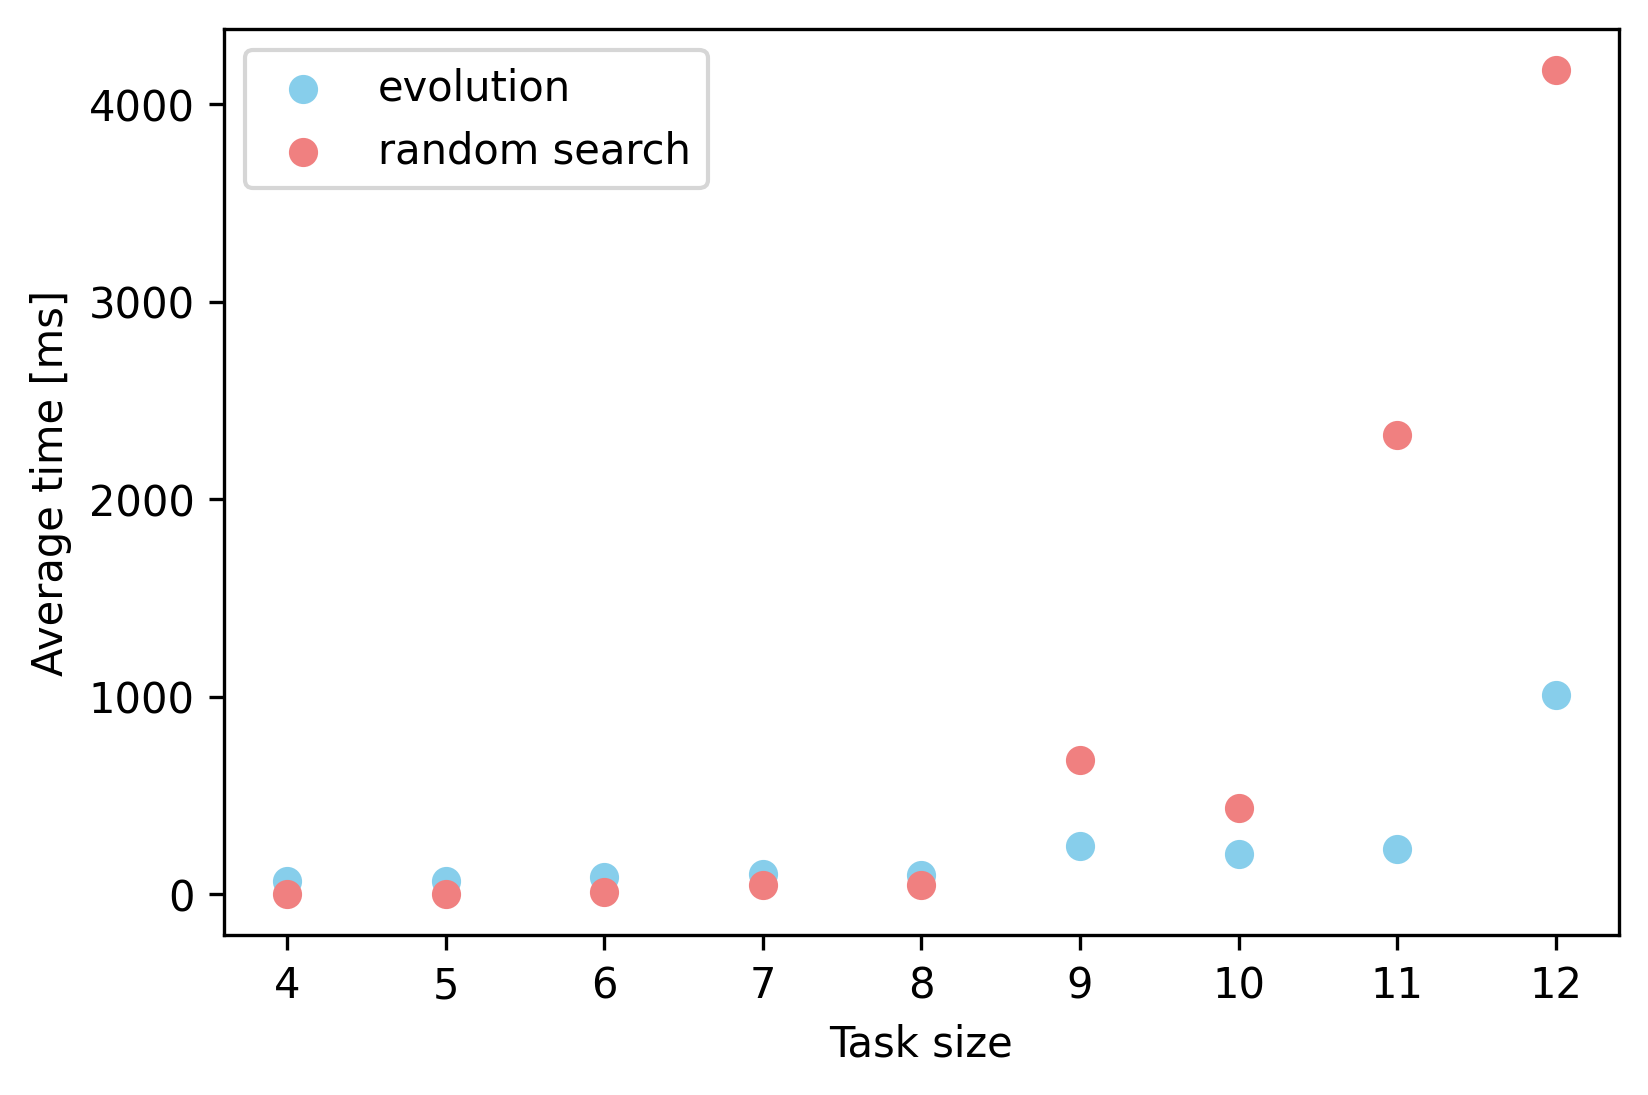

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# evolution settings
INDPB = 0.3
MUTPB = 0.8
CXPB = 0.1
GENERATION_COUNT = 2000
POPULATION_SIZE = 1500
TOURNAMENT_SIZE = 40

# analysis settings
MIN_TASK_LEN = 4
MAX_TASK_LEN = 12

# measure times
x = [i for  i in range(MIN_TASK_LEN, MAX_TASK_LEN + 1)]
y_evolution = []
y_random = []

for task_size in range(MIN_TASK_LEN, MAX_TASK_LEN + 1):
    time_evolution, time_random = compare(task_size, POPULATION_SIZE, GENERATION_COUNT, TOURNAMENT_SIZE, MUTPB, INDPB, CXPB)
    y_evolution.append(time_evolution)
    y_random.append(time_random)

# plot
plt.scatter(x, y_evolution, c='skyblue', label='evolution')
plt.scatter(x, y_random, c='lightcoral', label='random search')
plt.legend(loc='upper left')
plt.xlabel("Task size")
plt.ylabel("Average time [ms]")
plt.show()


Tasks between 4 and 12 numbers in size were evaluated. There were 5 samples taken for each of the task sizes.

The same plot plotted in a logarithmic scale can be seen below.

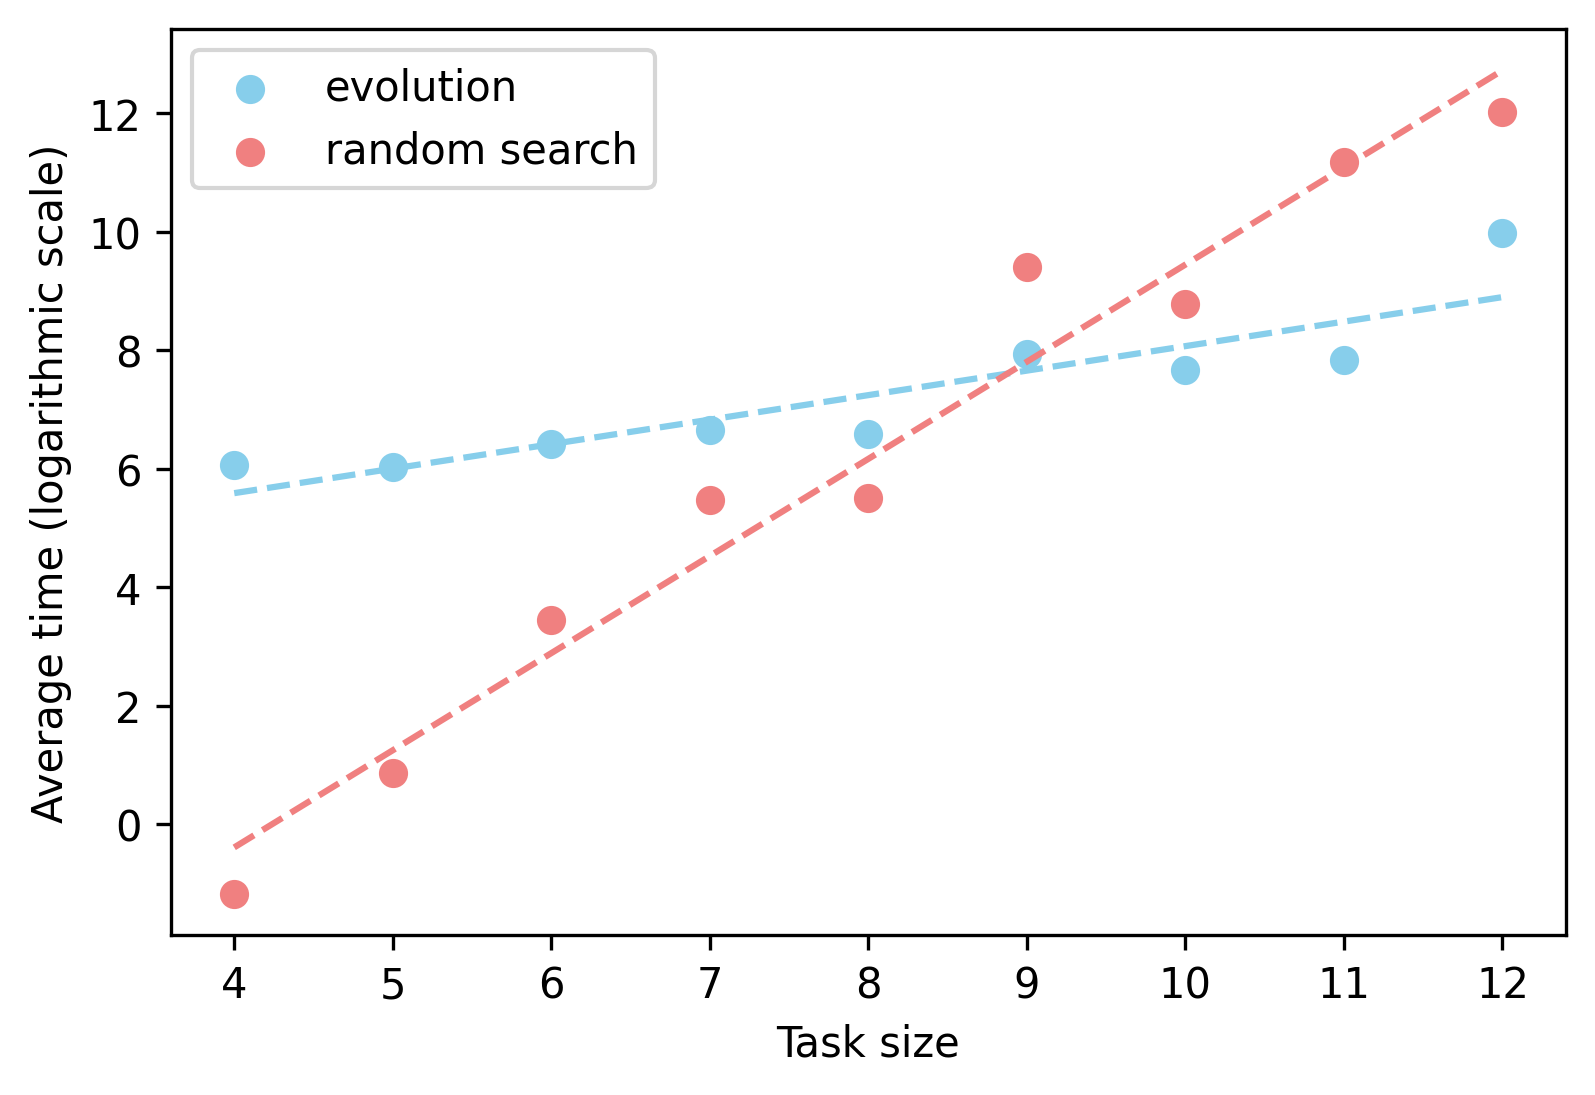

In [11]:
from math import log2
import numpy as np

# calculate logarithmic
y_evolution = [log2(i) for i in y_evolution]
y_random = [log2(i) for i in y_random]

# plot scatter
plt.scatter(x, y_evolution, c='skyblue', label='evolution')
plt.scatter(x, y_random, c='lightcoral', label='random search')

# fit lines
fit_evolution = np.polyfit(x, y_evolution, 1)
y_evolution_fit = [fit_evolution[1] + fit_evolution[0]*i for i in x]
fit_random = np.polyfit(x, y_random, 1)
y_random_fit = [fit_random[1] + fit_random[0]*i for i in x]

# plot lines
plt.plot(x, y_evolution_fit, 'skyblue', linestyle='dashed')
plt.plot(x, y_random_fit, 'lightcoral', linestyle='dashed')

plt.legend(loc='upper left')
plt.xlabel("Task size")
plt.ylabel("Average time (logarithmic scale)")
plt.show()

Random search appears to perform better for smaller task sizes (under 9). This is expected, as it omits some costly operations, such as:

- copying objects,
- tournament selection,
- mutation and
- crossover.

For longer tasks with more numbers, the evolution performs much better as it iteratively targets the best value instead of randomly trying to hit the target.

Tasks longer than 12 numbers were not evaluated due to a lack of computer power.

### Further considerations

There are several aspects of this report that could be improved. The two major flows are:

- The crossover function does not appear to be very productive. Some other methods were tried out but none of them produced better results.
- Optimal evolution parameters (generation count, population size, tournament size, crossover probability, mutation probability and individual gene mutation probability) are dependent on the task size at hand. For the sake of simplicity, this report only contains one set of parameters which works reasonably well on the task sizes. Therefore, the genetic algorithm could probably perform even better if configured for each task size individually.